In [704]:
import torch
import numpy as np
import string
import random
import sympy as sp

def generate_systems(m_list, xlen=1):
    systems = []
    variables = list(string.ascii_lowercase)
    xvars = variables[:xlen]
    variables = variables[xlen:]
    vars_used = xvars.copy()

    for m in m_list:
        A = torch.zeros((m, m))
        while np.linalg.matrix_rank(A) != m:
            A = torch.randint(-10, 11, size=(m, m), dtype=torch.float64)
        x = torch.randint(-10, 11, size=(m,), dtype=torch.float64)
        b = A @ x
        #print(A)
        #print(b)
        unique_vars = variables[:m]
        vars_used += unique_vars
        variables = variables[m:]
        systems.append((A, b, unique_vars))

    updated_systems = []
    for i in range(len(systems)):
        A, b, unique_vars = systems[i]
        other_vars_flat = [var for idx, (sys_A, sys_b, uv) in enumerate(systems) if idx != i for var in uv]
        #random int between 0 and len(other_vars_flat), distribution significantly favors lower numbers
        max_val = min(5, len(other_vars_flat))
        num_shared_vars = int(max_val**random.random())
        shared_vars = random.sample(other_vars_flat, num_shared_vars)
        max_val_x = min(2, len(xvars))
        num_xvars_picked = random.randint(0, max_val_x)
        shared_vars += random.sample(xvars, num_xvars_picked)

        # Extend A for shared variables
        for shared_var in shared_vars:
            if shared_var not in unique_vars:
                new_col = torch.zeros((A.shape[0], 1), dtype=torch.float64)
                # now set a random subset of the new column to be non-zero. Make sure at least one is non-zero
                new_col[torch.randint(0, A.shape[0], (1,)), 0] = torch.randint(-10, 11, (1,), dtype=torch.float64)
                A = torch.hstack((A, new_col))

        #residual_lambda = lambda *x, A=A, b=b: (A @ torch.cat([t.unsqueeze(0) for t in x])).squeeze() - b
        residual_lambda = lambda *x, A=A, b=b: ((sp.Matrix(A) @ sp.Matrix(x))- sp.Matrix(b))[0]
        solve_lambda = lambda *y, A=A, b=b, unique_vars=unique_vars: torch.from_numpy(np.linalg.solve(A[:, :len(unique_vars)], b - A[:, len(unique_vars):] @ torch.tensor(y)))

        updated_systems.append((shared_vars, unique_vars, residual_lambda, solve_lambda))

    return updated_systems, vars_used

In [ ]:
from src.v4.torchengine import AnalyticalSet, EliminateAnalysisMergeResiduals
import torch
# Set the print options
np.set_printoptions(formatter={'float': lambda x: "{:0.2f}".format(x).rstrip('0').rstrip('.')})

In [709]:
# Example usage
n = 20  # Number of systems
m_list = [1]*n  # Number of equations in each system

systems, variables = generate_systems(m_list, xlen=2)

In [710]:
indices = {var: torch.tensor([idx]) for idx, var in enumerate(variables)}

In [ ]:
from sympy import symbols
from src.v4.torchengine import reassigneq, AnalyticalSetSympy

varn = len(variables)
syms = symbols('x_1:%d' % (varn+1))
sym_indices = {var: torch.tensor([idx]) for idx, var in enumerate(syms)}

In [746]:
sets = {}
functional_sets = []
for idx, system in enumerate(systems):
    shared_vars, unique_vars, residual_lambda, solve_lambda = system
    set_original = AnalyticalSet((shared_vars, unique_vars, solve_lambda), indices,
                               forceresidual=(unique_vars+shared_vars, residual_lambda))
    sympy_residual = set_original.residual(syms)
    new_outputvar = syms[indices[unique_vars[0]].item()]
    sympy_analysis = reassigneq(None, sympy_residual, new_outputvar, rational=True)
    functional_sets.append(
        {'residual': str(sympy_residual), 
         'functionalvar': str(new_outputvar),
         'analysis': str(sympy_analysis)})
    sets[idx] = AnalyticalSetSympy(sympy_analysis, outputvar=new_outputvar, indices=sym_indices, forceresidual=sympy_residual)

In [747]:
# save json data
import json
json_data = {'functional_sets': functional_sets}
with open('../applications/data/linear_prob_size_20.json', 'w') as f:
    json.dump(json_data, f, indent=4)

In [748]:
sets[7].expression

10 - 3*x_21/2

In [633]:
# for set in sets.values():
#     print(set.analysis.structure)

In [733]:
x0 = torch.rand(len(variables), dtype=torch.float64)

In [734]:
for set in sets.values():
    arr = set.analysis(x0).numpy()
    formatted_arr = ['{:>6.2f}'.format(x) for x in arr]
    print('\t'.join(formatted_arr))

  0.18	  0.77	  5.54	  0.72	  0.78	  0.90	  0.20	  0.91	  0.26	  0.36	  0.54	  0.45	  0.42	  0.73	  0.01	  0.33	  0.79	  0.04	  0.32	  0.30	  0.77	  0.44
  0.18	  0.77	  0.66	  5.68	  0.78	  0.90	  0.20	  0.91	  0.26	  0.36	  0.54	  0.45	  0.42	  0.73	  0.01	  0.33	  0.79	  0.04	  0.32	  0.30	  0.77	  0.44
  0.18	  0.77	  0.66	  0.72	 -4.77	  0.90	  0.20	  0.91	  0.26	  0.36	  0.54	  0.45	  0.42	  0.73	  0.01	  0.33	  0.79	  0.04	  0.32	  0.30	  0.77	  0.44
  0.18	  0.77	  0.66	  0.72	  0.78	 -7.97	  0.20	  0.91	  0.26	  0.36	  0.54	  0.45	  0.42	  0.73	  0.01	  0.33	  0.79	  0.04	  0.32	  0.30	  0.77	  0.44
  0.18	  0.77	  0.66	  0.72	  0.78	  0.90	  7.92	  0.91	  0.26	  0.36	  0.54	  0.45	  0.42	  0.73	  0.01	  0.33	  0.79	  0.04	  0.32	  0.30	  0.77	  0.44
  0.18	  0.77	  0.66	  0.72	  0.78	  0.90	  0.20	  4.04	  0.26	  0.36	  0.54	  0.45	  0.42	  0.73	  0.01	  0.33	  0.79	  0.04	  0.32	  0.30	  0.77	  0.44
  0.18	  0.77	  0.66	  0.72	  0.78	  0.90	  0.20	  0.91	  0.69	  0.36	  0.54

In [735]:
R = EliminateAnalysisMergeResiduals([], [s.residual for s in sets.values()])

In [736]:
from torch.autograd.functional import jacobian

xvar = torch.zeros(len(variables), dtype=torch.float64, requires_grad=True)
J = jacobian(R, xvar)

In [737]:
Asol = J[:,2:].numpy()
bsol = -R(xvar).detach().numpy()

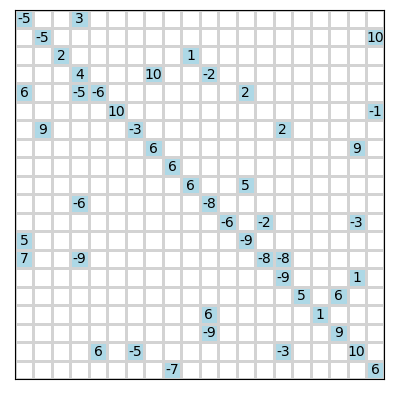

In [738]:
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# Print the system
A = Asol
b = bsol

# Create a figure and axis
fig, ax = plt.subplots()

# Create a custom color map
cmap = ListedColormap(['white', 'lightblue'])

# Flip A upside down
A_flipped = np.flipud(A)

# Use imshow to create a binary color map
cax = ax.pcolormesh(np.where(A_flipped != 0, 1, 0), cmap=cmap, edgecolors='lightgray', linewidth=1)

# Make cells square
ax.set_aspect('equal')

# Get the number of cells in x and y directions
num_cells_x = A.shape[1]
num_cells_y = A.shape[0]

# Add text at the center of the cells
for i in range(num_cells_y):
    for j in range(num_cells_x):
        if A[i, j] != 0:
            ax.text(j+0.5, num_cells_y-i-0.5, "{:0.2f}".format(A[i,j]).rstrip('0').rstrip('.'), ha='center', va='center')
            
ax.set_xticklabels([])
ax.set_yticklabels([])

# Optionally, remove the ticks as well
ax.set_xticks([])
ax.set_yticks([])

# Show the plot
plt.show()

In [620]:
edges = ({},{})
for set in sets.values():
    for elt in set.analysis.structure[1]:
        edges[0][f'f{elt.item()}'] = tuple(set.analysis.structure[0].tolist())
        edges[1][f'f{elt.item()}'] = (elt.item(),)
    print(set.analysis.structure)

(tensor([12,  1]), tensor([2]))
(tensor([14,  0]), tensor([3]))
(tensor([13,  3,  0]), tensor([4]))
(tensor([10, 13, 11,  1]), tensor([5]))
(tensor([12,  4, 15,  1]), tensor([6]))
(tensor([21,  0]), tensor([7]))
(tensor([17, 11,  1,  0]), tensor([8]))
(tensor([12,  0]), tensor([9]))
(tensor([21,  0]), tensor([10]))
(tensor([ 7, 13]), tensor([11]))
(tensor([13,  0]), tensor([12]))
(tensor([19, 11]), tensor([13]))
(tensor([ 3, 11]), tensor([14]))
(tensor([9, 5]), tensor([15]))
(tensor([ 5, 21]), tensor([16]))
(tensor([13,  0,  1]), tensor([17]))
(tensor([ 9, 11,  1]), tensor([18]))
(tensor([11]), tensor([19]))
(tensor([4, 0, 1]), tensor([20]))
(tensor([18, 13, 17]), tensor([21]))


In [621]:
from graph.graphutils import all_edges, all_variables, flat_graph_formulation
from graph.matrixview import render_incidence
from graph.operators import invert_edges, sort_scc, eqv_to_edges_tree
from presolver.tearing import min_arc_set_assign, min_arc_set
from collections import OrderedDict

In [622]:
edges_for_solving = invert_edges(*edges)
eqnidxs = list(edges[0].keys())
varidxs = all_variables(*edges_for_solving)
edges_left_right = all_edges(*edges_for_solving)
dout = {key:val[0] for key,val in edges[1].items()}
cycles, elimset,m = min_arc_set(edges_left_right, dout, varidxs, eqnidxs)

In [623]:
outset_opt = {key:val for key,val in dout.items() if key not in elimset}

In [624]:
edgesopt, _, _ = eqv_to_edges_tree(edges_for_solving[0], output_set=outset_opt, offset=False)
G = flat_graph_formulation(*edgesopt)
order = sort_scc(G)
treeopt = (OrderedDict([(list(elt)[0].name,1) for elt in order]),{},{})

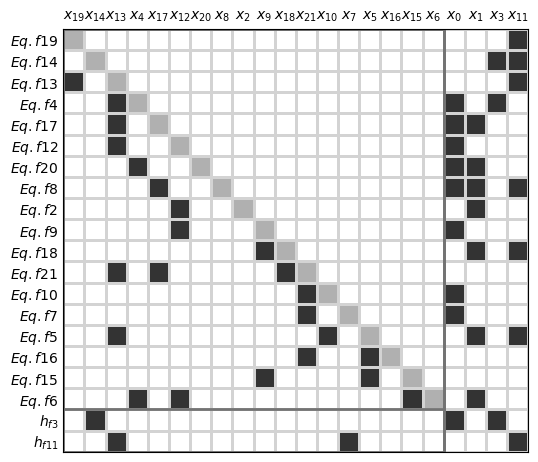

In [626]:
render_incidence(edgesopt, treeopt, rotation=0, hideticks=True, dispendcomp=True, figsize=((6,6)), fontsize=10);

In [481]:
solvevars = []
for s in sets.values():
    solvevars += [s.analysis.structure[1]]
solvevars = torch.cat(solvevars)

In [482]:
xsol = torch.from_numpy(np.linalg.solve(Asol, bsol))

In [483]:
xsol.numpy()

array([-7.58, -4.44, 6.43, -10.59, -15.72, -5.42, -9.51, 14.09, 11.82])

In [484]:
xfullsol = xvar.detach().clone()
xfullsol[solvevars] = xsol

In [485]:
for set in sets.values():
    arr = set.analysis(xfullsol).numpy()
    formatted_arr = ['{:>6.2f}'.format(x) for x in arr]
    print('\t'.join(formatted_arr))

  0.00	  0.00	 -7.58	 -4.44	  6.43	-10.59	-15.72	 -5.42	 -9.51	 14.09	 11.82
  0.00	  0.00	 -7.58	 -4.44	  6.43	-10.59	-15.72	 -5.42	 -9.51	 14.09	 11.82
  0.00	  0.00	 -7.58	 -4.44	  6.43	-10.59	-15.72	 -5.42	 -9.51	 14.09	 11.82
